<a href="https://colab.research.google.com/github/Arnava-03/prml_object_recognition/blob/main/object_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## **Data Preprocessing**

### LOADING THE DATASET

Reference of the dataset : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf  
Dataset and methodology followed is decribed in greater detail in the above cited link.


In [3]:
# we will load the cifar10 dataset from keras
# reference : https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf
# dataset and methodology followed is decribed in greater detail in the above cited link.
from keras.datasets import cifar10

(X_train, y_train),(X_test, y_test) = cifar10.load_data()


170498071/170498071 [==============================] - 6s 0us/step


ABOUT THE DATASET -


*   The dataset has 50000 training samples and 10000 test samples
*   cifar10 implies 10 class labels (or target labels)
*   Each sample has the shape (32,32,3)
*   Pixels in 32X32 images are indexed in values of three channels of Red, Blue and Green



In [12]:
print(f'Shape of the training set (features): {X_train.shape}')
print(f'Shape of the training set (target): {y_train.shape}')
print(f'Shape of the test set (features): {X_test.shape}')
print(f'Shape of the test set (target): {y_test.shape}')


Shape of the training set (features): (50000, 32, 32, 3)
Shape of the training set (target): (50000, 1)
Shape of the test set (features): (10000, 32, 32, 3)
Shape of the test set (target): (10000, 1)


### Visualizing the image set

Text(0.5, 1.0, 'A single image')

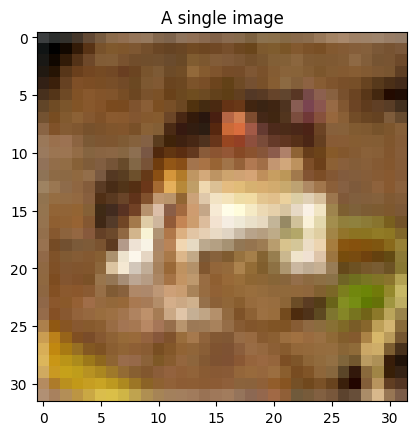

In [13]:
#plotting the first sample of the trainging set
plt.imshow(X_train[0])
plt.title('A single image')

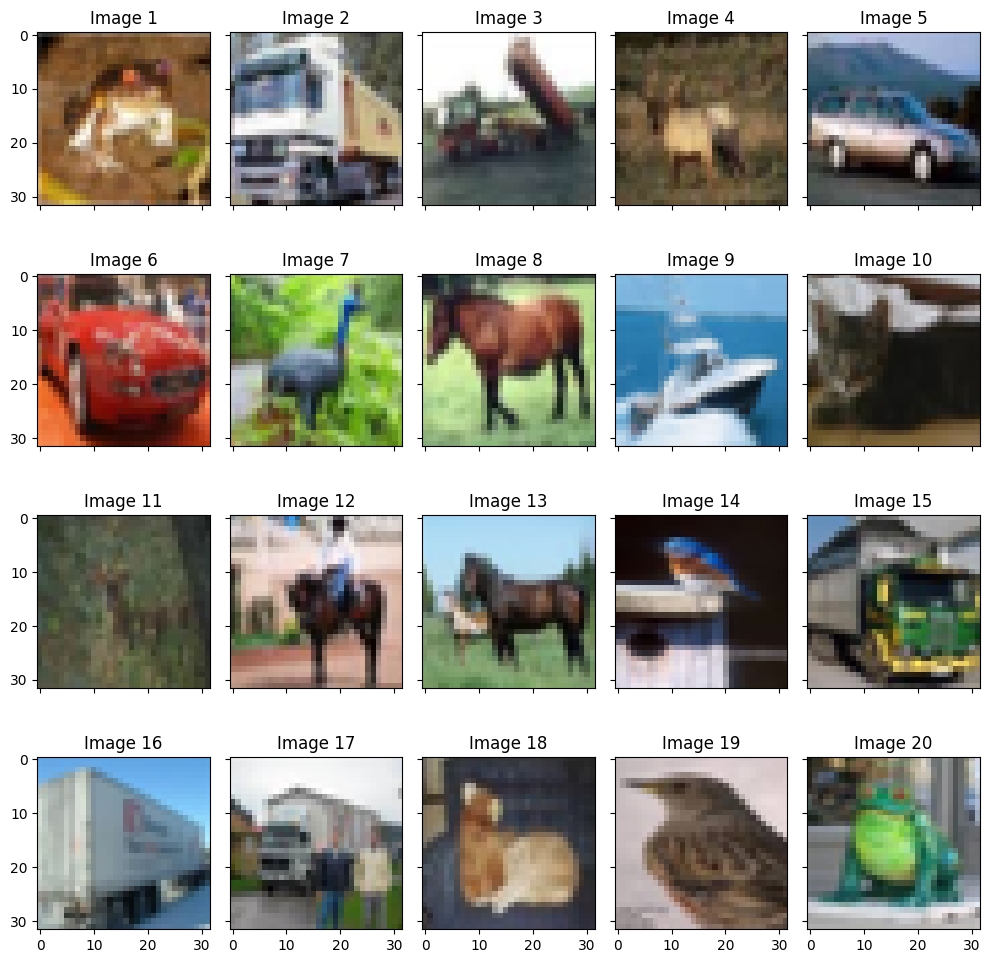

In [17]:
#making a subplot of first few images

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
  ax.imshow(X_train[i])
  ax.set_title(f'Image {i+1}')

plt.tight_layout()
plt.show()